# ML4N - Group Project 7
# Analysing Adversarial Attacks on Tabular Data Classifiers

In [55]:
# import needed python libraries
# Per ora ci ho messo quanta più roba potesse servire, in seguito rimuoviamo ciò che non serve 

%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import StrMethodFormatter
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


# 1 Data exploration and preprocessing

### 1.1 Dataset Acquisition ###

In [18]:
#List of Attributes for dataset acquired from german.doc
#good/bad is the label 1 means good customer while 2 means bad
attributes = ["Status_account", "Duration", "Credit_history","Purpose",
             "Credit_amount","Savings_account/bonds","Employment_since","Install_rate",
              "Personal_status_sex","debtors_guarantors","Present_residence_since",
              "Property","Age","Other_install_plans","Housing","No_credits","Job",
              "No_people_liable","Telephone","foreign_worker","good/bad"] 

#Acquiring dataset from german.data file
df = pd.read_csv("german.data", sep=' ', names = attributes)
df

,Status_account,Duration,Credit_history,Purpose,Credit_amount,Savings_account/bonds,Employment_since,Install_rate,Personal_status_sex,debtors_guarantors,...,Property,Age,Other_install_plans,Housing,No_credits,Job,No_people_liable,Telephone,foreign_worker,good/bad
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


### 1.2 Data Preprocessing ###

In [19]:
#Qualitative attributes that do not require encoding 
to_remove = ["Duration","Credit_amount","Install_rate","Present_residence_since",
             "Age","No_credits","No_people_liable","good/bad"] 

#Creating the list with the categorical attributes to be encoded
to_be_encoded = attributes.copy()
for el in to_remove:
    to_be_encoded.remove(el)

#Using One Hot Encoding to transform categorical attributes into qualitative ones
df_encoded = pd.get_dummies(df, columns=to_be_encoded, dtype = int)
display(df_encoded)

#Normalization between [0,1] and split into 80% training and 20% test 
#Note: Might be worth using k-fold Cross Validation or some other way
scaler = MinMaxScaler()


#K creation of the pandas dataframe of the normalized values
array_df_encoded2 = scaler.fit_transform(df_encoded)

df_normalized = pd.DataFrame(array_df_encoded2, columns=df_encoded.columns)

features = df_encoded.columns.drop("good/bad")
X, X_test, y, y_test = train_test_split(
    df_encoded[features], # X
    df_encoded['good/bad'], # y
    stratify = df_encoded['good/bad'], # stratify the dataset based on class labels
    train_size = 0.8, # percentage of training set
    random_state = 15 
)


X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

#Clearly define categories or classes ????? Maybe inside report????


,Duration,Credit_amount,Install_rate,Present_residence_since,Age,No_credits,No_people_liable,good/bad,Status_account_A11,Status_account_A12,...,Housing_A152,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,Telephone_A191,Telephone_A192,foreign_worker_A201,foreign_worker_A202
0,6,1169,4,4,67,2,1,1,1,0,...,1,0,0,0,1,0,0,1,1,0
1,48,5951,2,2,22,1,1,2,0,1,...,1,0,0,0,1,0,1,0,1,0
2,12,2096,2,3,49,1,2,1,0,0,...,1,0,0,1,0,0,1,0,1,0
3,42,7882,2,4,45,1,2,1,1,0,...,0,1,0,0,1,0,1,0,1,0
4,24,4870,3,4,53,2,2,2,1,0,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,1,0,0,...,1,0,0,1,0,0,1,0,1,0
996,30,3857,4,4,40,1,1,1,1,0,...,1,0,0,0,0,1,0,1,1,0
997,12,804,4,4,38,1,1,1,0,0,...,1,0,0,0,1,0,1,0,1,0
998,45,1845,4,4,23,1,1,2,1,0,...,0,1,0,0,1,0,0,1,1,0


### 1.3 Exploratory Data Analysis ###

In [20]:
#Histograms of average values

#creating a copy of the whole pandas df_encoded database and removing the label column

df_normalized_no_label = df_normalized.copy()
df_normalized_no_label = df_normalized.drop("good/bad", axis = 1)
display(df_normalized_no_label)

columns_means = df_normalized_no_label.mean().tolist()
columns_means



,Duration,Credit_amount,Install_rate,Present_residence_since,Age,No_credits,No_people_liable,Status_account_A11,Status_account_A12,Status_account_A13,...,Housing_A152,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,Telephone_A191,Telephone_A192,foreign_worker_A201,foreign_worker_A202
0,0.029412,0.050567,1.000000,1.000000,0.857143,0.333333,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,0.647059,0.313690,0.333333,0.333333,0.053571,0.000000,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.117647,0.101574,0.333333,0.666667,0.535714,0.000000,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.558824,0.419941,0.333333,1.000000,0.464286,0.000000,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.294118,0.254209,0.666667,1.000000,0.607143,0.333333,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.117647,0.081765,0.666667,1.000000,0.214286,0.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
996,0.382353,0.198470,1.000000,1.000000,0.375000,0.000000,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
997,0.117647,0.030483,1.000000,1.000000,0.339286,0.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
998,0.602941,0.087763,1.000000,1.000000,0.071429,0.000000,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


[0.2485735294117647,
 0.16624067348960053,
 0.6576666666666666,
 0.615,
 0.29546428571428573,
 0.13566666666666666,
 0.155,
 0.274,
 0.269,
 0.063,
 0.394,
 0.04,
 0.049,
 0.53,
 0.088,
 0.293,
 0.234,
 0.103,
 0.012,
 0.181,
 0.28,
 0.012,
 0.022,
 0.05,
 0.009,
 0.097,
 0.603,
 0.103,
 0.063,
 0.048,
 0.183,
 0.062,
 0.172,
 0.339,
 0.174,
 0.253,
 0.05,
 0.31,
 0.548,
 0.092,
 0.907,
 0.041,
 0.052,
 0.282,
 0.232,
 0.332,
 0.154,
 0.139,
 0.047,
 0.814,
 0.179,
 0.713,
 0.108,
 0.022,
 0.2,
 0.63,
 0.148,
 0.596,
 0.404,
 0.963,
 0.037]

# 2 Unsupervised exploration and clustering #

### 2.1 Dimensionality reduction for data visualization ###

<function matplotlib.pyplot.show(close=None, block=None)>

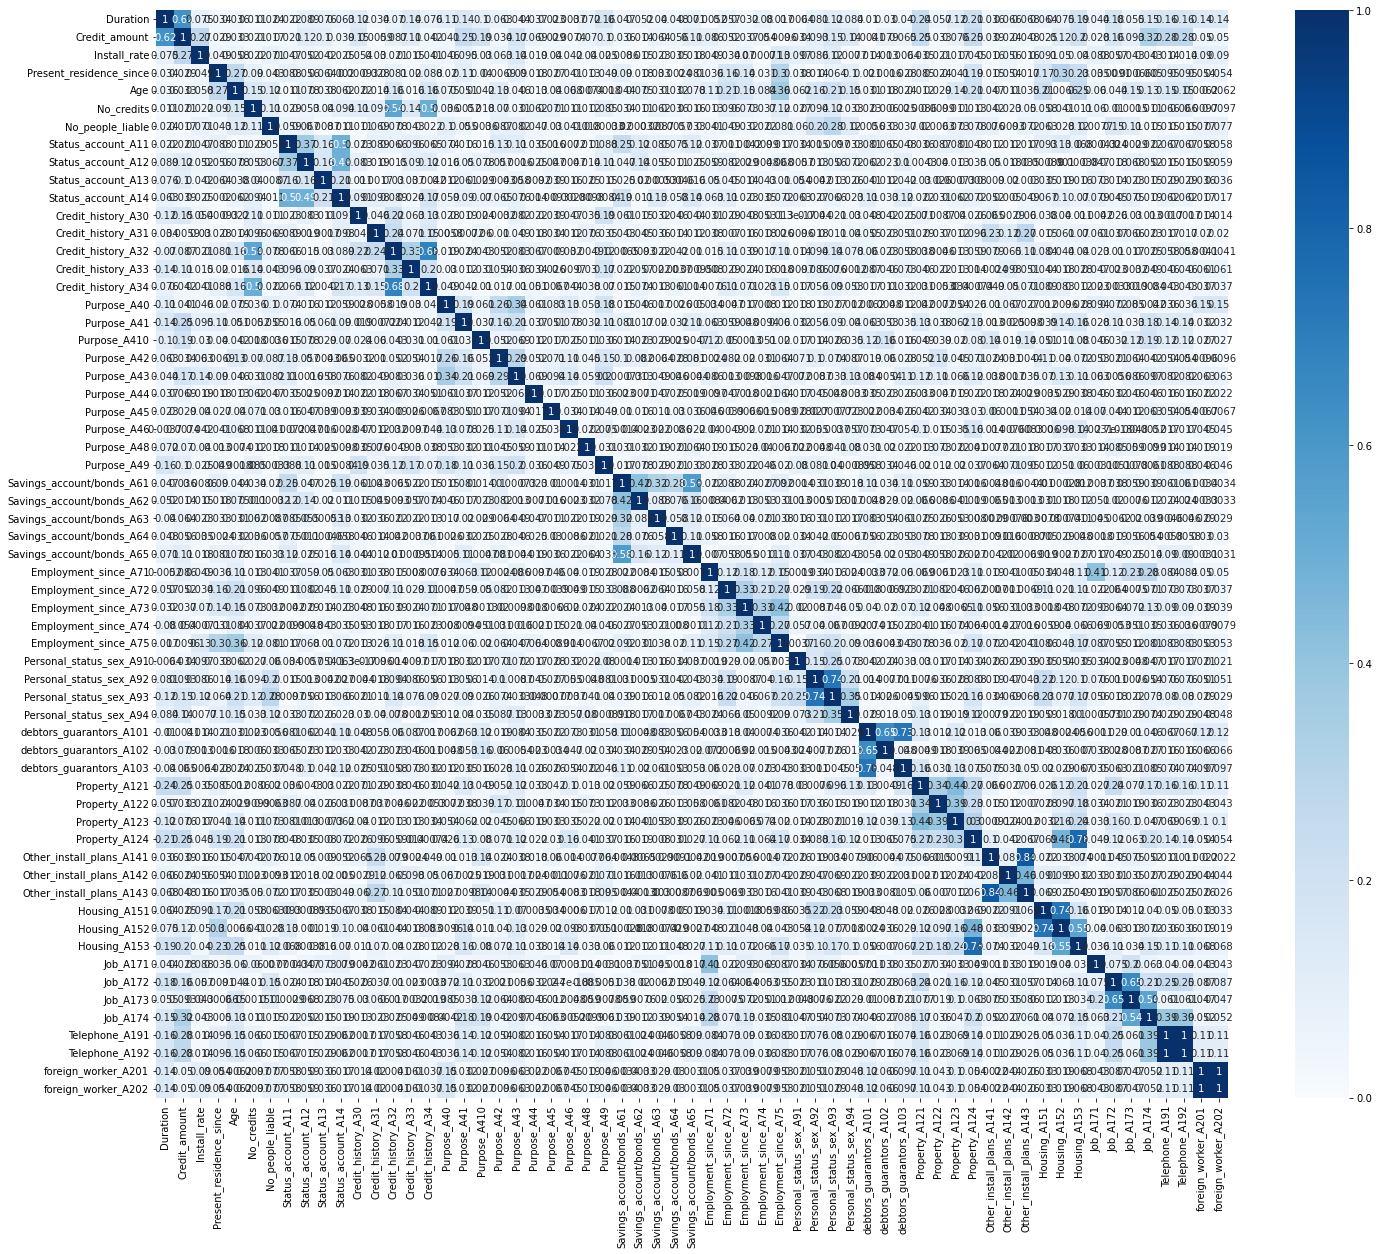

In [21]:
# Apply dimensionality reduction techniques: t-Distributed Stochastic Neighbor Embedding (t-SNE)
# and Principal Component Analysis (PCA) to reduce and visualize the data.

#I compute the correlation between the features to see if there are any correlated features
correlation_analysis = df_normalized_no_label.corr().abs()

plt.figure(figsize = (24,20))
sns.heatmap(correlation_analysis, cmap="Blues", annot=True)
plt.show


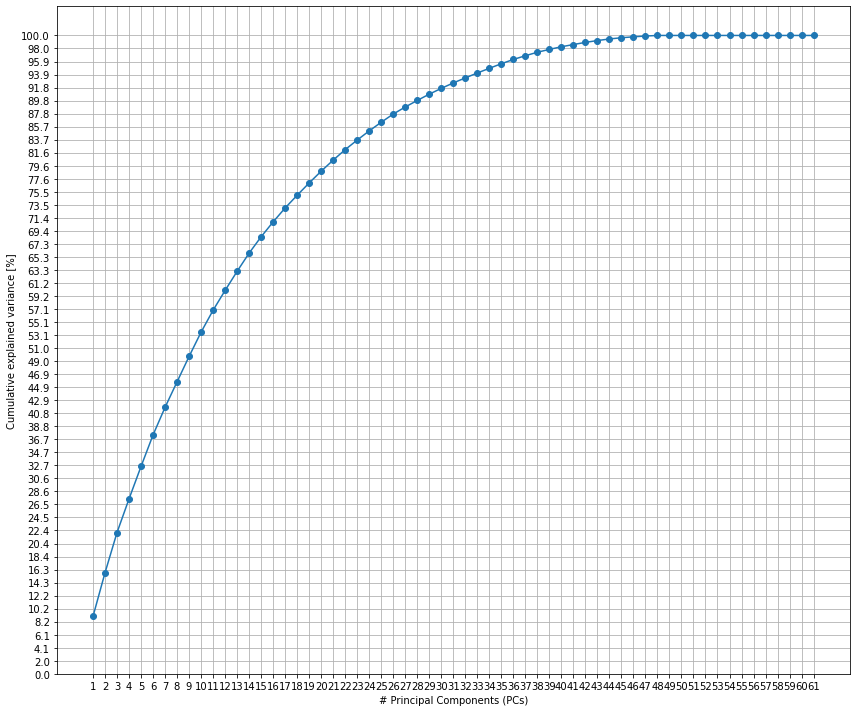

In [22]:
#Aproximately 10 columns will be removed by performing PCA

columns_no_label = df_normalized_no_label.columns
pca = PCA(random_state = 15)
pca.fit(df_normalized_no_label[columns_no_label])


explained_variance = pca.explained_variance_ratio_ #Here i compute the variability of the dataset, while the varaible number keeps increasing, 
                                                    #until reaching all the number
cum_exp_var = np.cumsum(explained_variance)    #This allows to represent the sum for each step (remember 61 features)
perc_cum_exp_var = cum_exp_var * 100          #Representing it in percentage
 

# make the plot of cumulative explained variance wrt number of components
plt.figure(figsize=(12, 10))
plt.plot(perc_cum_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(61)], [i for i in range(1,62)])
plt.yticks(np.linspace(0,100, 50))
plt.grid()
plt.tight_layout()
plt.show()

# for i in range (len(perc_cum_exp_var)):
#     print(i, ":", perc_cum_exp_var[i])



In [23]:
# I Apply t-SNE for dimensionality reduction
perplexities = [5, 10, 20, 30, 50]
learning_rate = np.linspace(10, 1000, 5)

plt.figure(figsize=(15, 10))

for i, perplexity in enumerate(perplexities, 1):
    for lr in learning_rate:
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, learning_rate = lr)
        X_tsne = tsne.fit_transform(df_normalized_no_label[columns_no_label])
        if (perplexity == 5 and lr == 10):
            transformed_df_t_sne = pd.DataFrame(X_tsne, columns = ['C1', 'C2'])

        # scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
        # plt.title(f't-SNE Visualization (Perplexity={perplexity}, Learning Rate={lr})')
        # plt.show()

transformed_df_t_sne

,C1,C2
0,9.387000,45.106659
1,-21.120193,-25.617643
2,-48.730602,24.894571
3,-40.195545,8.426905
4,43.167259,44.267723
...,...,...
995,-20.166744,-7.803782
996,47.526978,4.838389
997,-8.807094,29.463387
998,35.353855,29.948048


<Figure size 1080x720 with 0 Axes>

In [28]:
#I choose 45 components because i'll be able to describe 99.78% of the entire dataset
pca = PCA(n_components = 45, random_state = 15)
pca.fit(df_normalized_no_label[columns_no_label])

transformed_df = pca.transform(df_normalized_no_label[columns_no_label])

columns_transformed_df = [f'PC{i}' for i in range(0,45)]

transformed_df_pca = pd.DataFrame(transformed_df, columns=columns_transformed_df)
transformed_df_pca


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
0,1.093896,-0.671381,0.071017,0.303321,0.084118,-0.110836,-0.417682,-0.405371,-0.494935,1.206839,...,-0.051767,-0.047520,-0.016265,-0.176023,-0.229730,0.257222,-0.096840,-0.016339,0.009934,-0.018230
1,-1.416504,0.091914,-0.554413,-0.452032,-0.045156,0.024576,-0.116422,-0.824051,0.472686,0.642354,...,-0.002902,0.209375,-0.016502,0.097444,0.409955,0.022784,0.073513,0.032875,-0.049032,-0.024050
2,-0.057365,-1.337976,0.891651,-0.151722,0.760248,0.422291,-0.351408,-0.055940,-0.264468,-0.330179,...,0.123963,0.066528,0.166973,-0.031675,0.116573,0.029484,-0.296427,-0.161382,0.141104,-0.034739
3,-0.338916,0.466398,1.126655,0.462158,-1.028936,-0.841165,-0.381969,0.710006,-0.219607,0.283009,...,-0.155147,-0.789908,0.084449,-0.544072,0.558166,0.062337,0.042896,-0.074917,0.138670,0.021247
4,0.126734,0.099974,1.483677,0.675505,-0.634900,-0.680912,-0.411220,-0.133550,1.048460,-0.340213,...,-0.046090,-0.072256,-0.078165,-0.108399,-0.092325,0.176682,-0.040676,0.046013,-0.011625,0.038202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.110720,-0.061561,-0.003418,-0.086625,0.626471,0.668443,-0.488642,0.089493,-0.819155,-0.394127,...,-0.020371,0.041994,0.019686,0.031693,0.017673,-0.079988,-0.048000,0.033705,0.033427,-0.007414
996,0.324920,1.041201,0.087038,-0.856791,0.197064,-0.279203,-0.891673,0.673756,-0.135778,-0.094908,...,-0.260133,0.221969,0.018994,0.021738,-0.048504,-0.062509,-0.014422,0.156565,0.130610,-0.073580
997,-0.014915,-0.808939,-0.476231,0.140822,-0.916645,-0.492958,0.034228,-0.701504,-1.033103,-0.417114,...,0.084741,-0.024112,-0.082296,0.018459,-0.073524,-0.070119,-0.026942,-0.003834,0.059109,0.009936
998,0.572306,0.895386,0.367433,0.039532,-0.977372,-0.702488,-1.093898,-0.798148,0.352825,0.164899,...,-0.000030,-0.012743,-0.094626,0.020943,0.189848,-0.246600,0.089896,0.025258,0.066402,-0.018669


<function matplotlib.pyplot.show(close=None, block=None)>

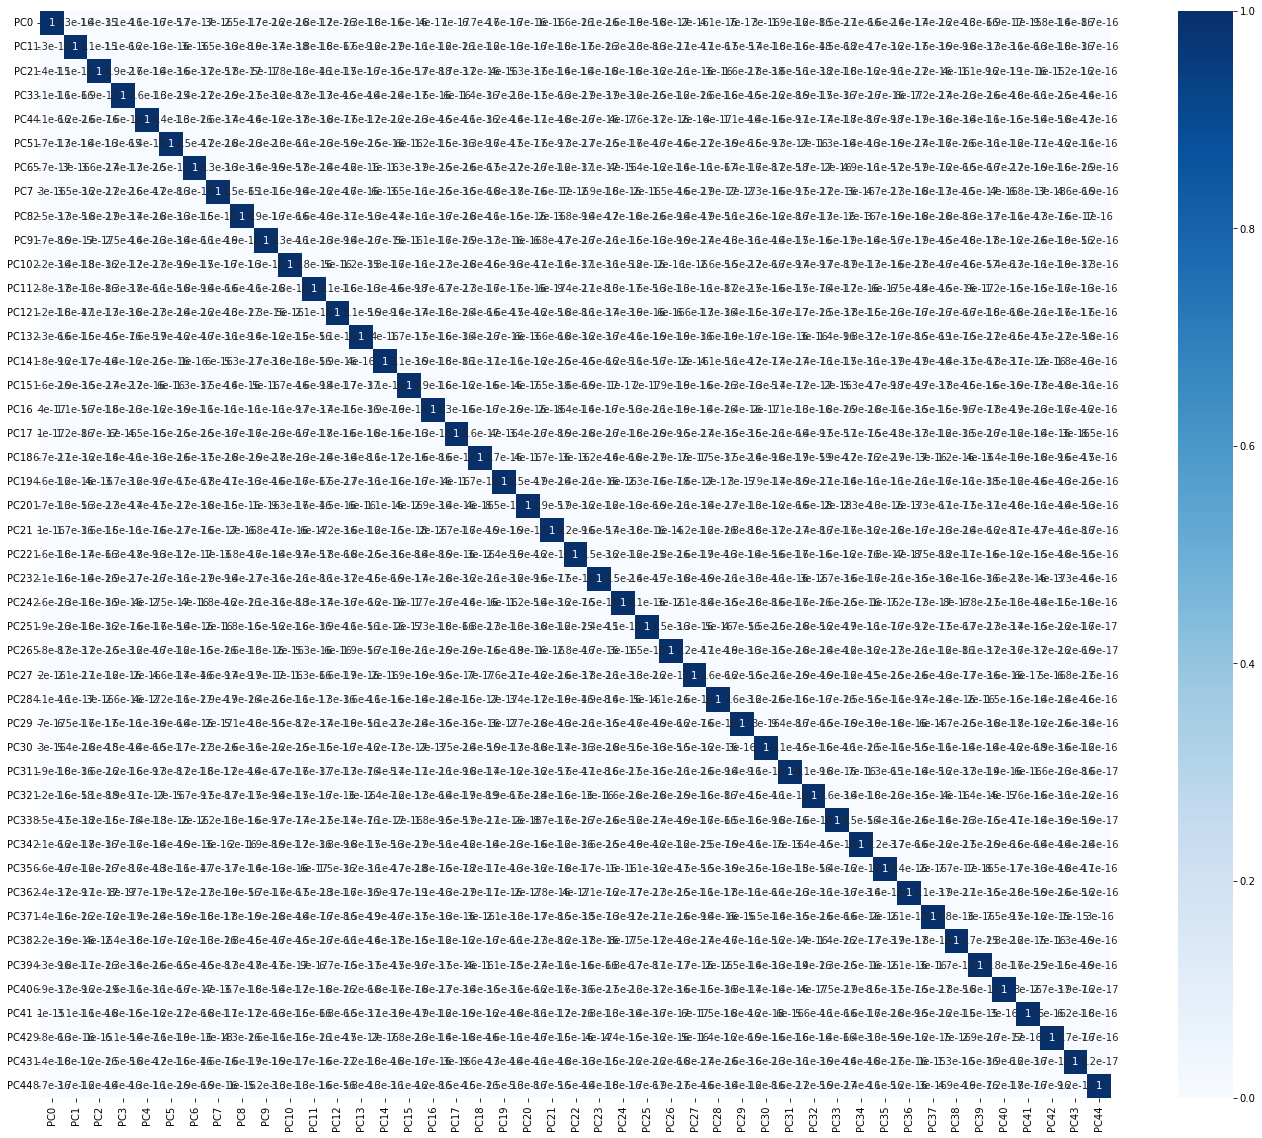

In [29]:
#Compute the correlation matrix after PCA
correlation_analysis = transformed_df_pca.corr().abs()

plt.figure(figsize = (24,20))
sns.heatmap(correlation_analysis, cmap="Blues", annot=True)
plt.show

#transormed_df_pca is the transformed dataset using PCA, it will have 45 features, with a total variance of the dataset of %99,78

#     3 Supervised Data Analysis

3.1 Classifier Selection (DecisionTree, NaiveBayes, NN to be decided)

In [37]:
#Splitting the into sets once again after PCA
X, X_test, y, y_test = train_test_split(
    transformed_df_pca[transformed_df_pca.columns], # X
    df_encoded['good/bad'], # y
    stratify = df_encoded['good/bad'], # stratify the dataset based on class labels
    train_size = 0.8, # percentage of training set
    random_state = 15 
)

Versions using GridSearchCV (not sure it's correct)

In [53]:
#DecisionTree

parameters = {"criterion":('gini', 'entropy', 'log_loss'), 'max_depth':[None, 4, 6, 8],
              'min_samples_split':[2, 3, 4]}

#further split into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    stratify = y, 
    train_size = 0.5/0.8, 
    random_state = 40
)

DT = DecisionTreeClassifier()
clf_DT = GridSearchCV(DT, parameters, cv = 20, scoring = 'precision')
clf_DT.fit(X_train, y_train)
print('Best Criterion:', clf_DT.best_estimator_.get_params()['criterion'])
print('Best max_depth:', clf_DT.best_estimator_.get_params()['max_depth'])
print('Best Score:', clf_DT.best_score_)


Best Criterion: log_loss
Best max_depth: None
Best Score: 0.7789123292857812


In [52]:
#GaussianNaiveBayes
parameters = {"var_smoothing":(np.logspace(-4,0,5))}

#further split into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    stratify = y, 
    train_size = 0.5/0.8, 
    random_state = 40
)

GNB = GaussianNB()
clf_GNB = GridSearchCV(GNB, parameters, cv = 20, scoring = 'precision')
clf_GNB.fit(X_train, y_train)
print('Best Var_Smoothing:', clf_GNB.best_estimator_.get_params()['var_smoothing'])
print('Best Score:', clf_GNB.best_score_)


Best Var_Smoothing: 0.001
Best Score: 0.7703064591067686


Manual Hyperparameters search

In [64]:
# iterate over all possible combinations of hyperparameters for decisionTreeClassifier
best_combination = [0,1,2,3]
acc_max = 0
idx = -1
idx_best = idx
info_accuracy_train = []
info_accuracy_val = []

for criterion in ['gini', 'entropy']:
    for max_depth in [4, 6, 8, None]:
        for min_samples_split in [2, 3, 4]:
            idx += 1

            random_states = set()
            while len(random_states) < 5:
                n = random.randint(0,1000000)
                random_states.add(n)
        
            accuraries_train_tmp = []
            accuraries_val_tmp = []
            
            # iterate over all random states with same training size to derive the 10 different performance
            for random_state in random_states:
                # further split into training and validation
                X_train_s, X_val_s, y_train, y_val = train_test_split(
                    X, y, 
                    stratify = y, 
                    train_size = 0.5/0.8, 
                    random_state = random_state
                )

                # initialize and fit a model per combination of parameters
                dt_tmp = DecisionTreeClassifier(
                    criterion = criterion, 
                    max_depth = max_depth, 
                    min_samples_split = min_samples_split,
                    random_state = 0
                )
                dt_tmp.fit(X_train_s, y_train)
                accuraries_train_tmp.append(accuracy_score(y_train, dt_tmp.predict(X_train_s)))
                accuraries_val_tmp.append(accuracy_score(y_val, dt_tmp.predict(X_val_s)))
        
            # calculate the statistics to generate overall performance
            accuraries_tmp = np.array(accuraries_train_tmp)
            mean_acc = accuraries_tmp.mean()
            min_acc = accuraries_tmp.min()
            max_acc = accuraries_tmp.max()
            info_accuracy_train.append((mean_acc, min_acc, max_acc))
            
            accuraries_tmp = np.array(accuraries_val_tmp)
            mean_acc = accuraries_tmp.mean()
            min_acc = accuraries_tmp.min()
            max_acc = accuraries_tmp.max()
            info_accuracy_val.append((mean_acc, min_acc, max_acc))

            if mean_acc >= acc_max:
                idx_best = idx
                acc_max = mean_acc
                best_combination[0] = criterion
                best_combination[1] = max_depth
                best_combination[2] = min_samples_split

print('Best:')
print(
    f'criterion: {best_combination[0]}, ' + \
    f'max_depth: {best_combination[1]}, ' + \
    f'min_samples_split: {best_combination[2]}'
)

Best:
criterion: entropy, max_depth: 4, min_samples_split: 3


In [93]:
# iterate over all possible combinations for gaussianNaiveBayes

#QUESTION FOR PROF RANGE OF VAR_SMOOTHING

acc_max = 0
idx = -1
idx_best = idx
info_accuracy_train = []
info_accuracy_val = []

for var_smoothing in (np.logspace(-4,0,5)):
    idx += 1

    random_states = set()
    while len(random_states) < 5:
        n = random.randint(0,1000000)
        random_states.add(n)

    accuraries_train_tmp = []
    accuraries_val_tmp = []
    
    # iterate over all random states with same training size to derive the 10 different performance
    for random_state in random_states:
        # further split into training and validation
        X_train_s, X_val_s, y_train, y_val = train_test_split(
            X, y, 
            stratify = y, 
            train_size = 0.5/0.8, 
            random_state = random_state
        )

        # initialize and fit a model per combination of parameters
        gnb_tmp = DecisionTreeClassifier(random_state = 0)
        gnb_tmp.fit(X_train_s, y_train)
        accuraries_train_tmp.append(accuracy_score(y_train, gnb_tmp.predict(X_train_s)))
        accuraries_val_tmp.append(accuracy_score(y_val, gnb_tmp.predict(X_val_s)))
        
    # calculate the statistics to generate overall performance
    accuraries_tmp = np.array(accuraries_train_tmp)
    mean_acc = accuraries_tmp.mean()
    min_acc = accuraries_tmp.min()
    max_acc = accuraries_tmp.max()
    info_accuracy_train.append((mean_acc, min_acc, max_acc))
    
    accuraries_tmp = np.array(accuraries_val_tmp)
    mean_acc = accuraries_tmp.mean()
    min_acc = accuraries_tmp.min()
    max_acc = accuraries_tmp.max()
    info_accuracy_val.append((mean_acc, min_acc, max_acc))

    if mean_acc >= acc_max:
        idx_best = idx
        acc_max = mean_acc
        best = var_smoothing
        
print('Best:')
print(f'var_smoothing: {best}')

Best:
var_smoothing: 0.1
